In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random
from scipy.spatial import distance
from sklearn import cluster
from sklearn.decomposition import PCA

## 2. Grouping songs together!

### 2.1 Getting your data!

In [2]:
echonest = pd.read_csv('echonest.csv', encoding='utf8')
features = pd.read_csv('features.csv')
tracks = pd.read_csv('tracks.csv')

In [3]:
print(echonest.shape)
print(features.shape)
print(tracks.shape)

(13129, 250)
(106574, 519)
(106574, 53)


In [80]:
# Merge the dataset in order to have information about echonest track (left merge - index of echonest)
# We merge with the key = 'track_id'
merged_df = pd.merge(pd.merge(echonest, features, on='track_id', how='left'), tracks, on='track_id', how='left')
# We store the merged dataset to avoid to compute it each time
merged_df.to_csv('merged_df.csv')

In [90]:
merged_df.describe()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_latitude,...,artist_id,artist_latitude,artist_longitude,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number
count,13129.000000,1.312900e+04,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,9770.000000,...,13129.000000,8052.000000,8052.000000,13129.000000,13129.000000,13129.000000,13129.000000,1.312900e+04,13129.000000,13129.000000
mean,34031.058268,5.246876e-01,0.487290,0.537516,0.640536,0.187804,0.099174,123.080061,0.439761,39.961892,...,6303.865641,40.144635,-49.099826,248580.807068,0.044558,249.013558,4.310305,3.784447e+03,2147.068703,5.608500
std,28950.422182,3.837186e-01,0.190148,0.278049,0.361430,0.158051,0.137381,35.015137,0.276028,15.554275,...,4974.103114,15.603089,57.881761,63834.230395,0.494095,207.268166,20.884705,3.396744e+04,9434.471644,6.108004
min,2.000000,9.035000e-07,0.051307,0.000020,0.000000,0.025297,0.022324,12.753000,0.000010,-45.867100,...,1.000000,-43.532054,-123.114034,-1.000000,0.000000,18.000000,0.000000,6.300000e+01,12.000000,0.000000
25%,12986.000000,1.037726e-01,0.344759,0.321300,0.323466,0.101406,0.036932,95.967000,0.197321,37.784827,...,2203.000000,37.871166,-85.111004,192000.000000,0.000000,156.000000,0.000000,6.700000e+02,299.000000,2.000000
50%,28097.000000,5.739848e-01,0.485635,0.549113,0.838134,0.119002,0.049019,120.057000,0.417743,40.781400,...,5442.000000,40.714550,-73.950000,256000.000000,0.000000,214.000000,1.000000,1.351000e+03,694.000000,4.000000
75%,45021.000000,9.207270e-01,0.629094,0.776254,0.918244,0.211041,0.085452,145.318000,0.665575,47.254575,...,9288.000000,47.218371,-0.045680,320000.000000,0.000000,282.000000,4.000000,2.948000e+03,1714.000000,8.000000
max,124911.000000,9.957965e-01,0.968645,0.999964,0.998016,0.980330,0.966177,251.072000,0.999990,68.927500,...,20818.000000,65.201935,174.885971,448000.000000,37.000000,3033.000000,1482.000000,3.293557e+06,543252.000000,213.000000


In [66]:
merged_df.iloc[:, :100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 100 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          13129 non-null  int64  
 1   track_id                            13129 non-null  int64  
 2   audio_features_acousticness         13129 non-null  float64
 3   audio_features_danceability         13129 non-null  float64
 4   audio_features_energy               13129 non-null  float64
 5   audio_features_instrumentalness     13129 non-null  float64
 6   audio_features_liveness             13129 non-null  float64
 7   audio_features_speechiness          13129 non-null  float64
 8   audio_features_tempo                13129 non-null  float64
 9   audio_features_valence              13129 non-null  float64
 10  metadata_album_date                 2717 non-null   object 
 11  metadata_album_name                 2872

In [19]:
# to avoid to merge each time
merged_df = pd.read_csv('merged_df.csv')
merged_df.shape

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (811,816,818) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(13129, 821)

### 2.2 Choose your features (variables)! TO DO

In [20]:
#drop columns with too few values (less than the half)

col_dropped=[]
for col in merged_df.columns:
    nb_missed = merged_df[col].isna().sum() 
    n = merged_df.shape[0]
    if nb_missed > 7500 :
        col_dropped.append(col)
        merged_df.drop([col], axis = 1, inplace = True)


In [21]:
#print dropped column to be sure to not drop a very relevant attribute
print(col_dropped)

['metadata_album_date', 'metadata_album_name', 'ranks_artist_discovery_rank', 'ranks_artist_familiarity_rank', 'ranks_artist_hotttnesss_rank', 'ranks_song_currency_rank', 'ranks_song_hotttnesss_rank', 'album_engineer', 'album_producer', 'artist_active_year_begin', 'artist_active_year_end', 'artist_associated_labels', 'artist_related_projects', 'artist_wikipedia_page', 'track_composer', 'track_date_recorded', 'track_information', 'track_lyricist', 'track_publisher']


#### Encode the values

In [22]:
# for variables which represent dates we will use the datetime type and transform it in numerical values
res = []
for col in merged_df.columns:
    if ('date' in col) or ('year' in col):
        #print(col)
        #print(merged_df[[col]].isna().sum())
        merged_df[col] = pd.to_numeric(pd.to_datetime(merged_df[col], format = "%Y-%m-%d"))


In [23]:
merged_df.info(verbose = 1) # we have only 3 types : int, float or object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 802 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    Unnamed: 0                          int64  
 1    track_id                            int64  
 2    audio_features_acousticness         float64
 3    audio_features_danceability         float64
 4    audio_features_energy               float64
 5    audio_features_instrumentalness     float64
 6    audio_features_liveness             float64
 7    audio_features_speechiness          float64
 8    audio_features_tempo                float64
 9    audio_features_valence              float64
 10   metadata_artist_latitude            float64
 11   metadata_artist_location            object 
 12   metadata_artist_longitude           float64
 13   metadata_artist_name                object 
 14   metadata_release                    object 
 15   social_features_artist_discovery  

### add mean value in columns with a few NAN ???

#encoded value
encoded_df = merged_df.copy()

for col in encoded_df.columns:
    
    #columns with non-numeric values
    if encoded_df[col].dtype == object :
        #replace missing values by 'None'
        encoded_df[col].fillna("None", inplace = True)  
        le = preprocessing.LabelEncoder()
        encoded_df[col]= le.fit_transform(encoded_df[col])
    
    else :
        #replace missing values by the mean of the column
        if (encoded_df[col].dtype == float) or (encoded_df[col].dtype == int):
            encoded_df[col].fillna(encoded_df[col].mean(), inplace = True)
        

In [25]:
# store and encode object values + store numerical value in two different DataFrame
encoded_df = pd.DataFrame()
num_df = pd.DataFrame()

for col in merged_df.columns:
    
    #columns with non-numeric values
    if merged_df[col].dtype == object :
        #replace missing values by 'None'
        merged_df[col].fillna("None", inplace = True)  
        le = preprocessing.LabelEncoder()
        encoded_df[col]= le.fit_transform(merged_df[col])
    
    #columns with numeric values
    else :
        #replace missing values by the mean of the column
        #if (merged_df[col].dtype == float) or (merged_df[col].dtype == int):
        merged_df[col].fillna(merged_df[col].mean(), inplace = True)
        num_df[col] = merged_df[col]
        

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [30]:
print('merged_df' , merged_df.shape)
print('encoded_df' , encoded_df.shape)
print('num_df' , num_df.shape)

merged_df (13129, 802)
encoded_df (13129, 22)
num_df (13129, 780)


#### Apply PCA only to numerical values

In [57]:
#normalize for ACP
X1 = num_df.to_numpy()
Z1 = preprocessing.StandardScaler().fit_transform(X1) # normalize

#pca = PCA(n_components=Z.shape[1])
pca = PCA(n_components = 68)
A = pca.fit_transform(Z1)

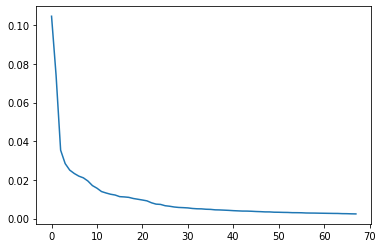

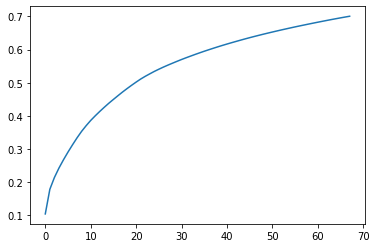

The partial variance is equal to : 0.7002644346866692


In [58]:
#print(pca.explained_variance_ratio_)
print("The partial variance is equal to :", np.cumsum(pca.explained_variance_ratio_)[-1])

#### Normalize the object dataset

In [62]:
X2 = encoded_df.to_numpy()
Z2 = preprocessing.StandardScaler().fit_transform(X2)

In [72]:
Z2.shape

(13129, 22)

In [73]:
A.shape

(13129, 68)

In [79]:
# final reducted matrix
Z = np.hstack((A, Z2))
Z.shape

(13129, 90)

### 2.3 Clustering!

In [80]:
def KMeans(X, k, max_it = 100):
    #choose randomly points of X to initialize our centroids
    ind_centroids = random.sample(range(len(X)),k)
    #initialization of the centroids
    centroids = X[ind_centroids, :]
    #init the associated cluster for each point
    previous_clusters = [np.full(len(X), -1)]
    clusters = np.full(len(X), -1)
    
    distances = np.array([np.linalg.norm(X - centroids[i], axis = 1) for i in range(k)]).T
    clusters = np.argmin(distances, axis = 1)
    count = 0
    while (clusters != previous_clusters[-1]).any() and (count <= max_it):
        previous_clusters.append(clusters)
        # update the centroids
        for j in range(k):
            centroids[j] = np.mean(X[clusters==j,:], axis=0)
        distances = np.array([np.linalg.norm(X - centroids[i], axis = 1) for i in range(k)]).T
        clusters = np.argmin(distances, axis = 1)
        count+=1
        
    return clusters, centroids, count

In [117]:
#test


# TO DELETE



dataset = pd.read_csv('iris.csv')

clusters, _, _ = KMeans(dataset[['petal.width', 'petal.length']].to_numpy(), 3, max_it = 100)

from sklearn.metrics import confusion_matrix
y_true = []
for el in dataset.variety:
    if el == 'Setosa':
        y_true.append(0)
    elif el == 'Virginica':
        y_true.append(1)
    else:
        y_true.append(2)
confusion_matrix(y_true, clusters)

# it work

array([[ 0,  0, 50],
       [46,  4,  0],
       [ 2, 48,  0]], dtype=int64)

In [101]:
random.seed(0)
%time clusters, centroids, count = KMeans(Z, 3, max_it = 100)
# i dont understand why the algo running is longer for normalized values

Wall time: 1.51 s


In [102]:
clusters

array([0, 0, 0, ..., 2, 0, 1], dtype=int64)

#### Method to find an optimal number of clusters
1. Elbow method

In [83]:
def compute_elbow(X, cluster_labels, centroids):
    C = np.array([centroids[k] for k in cluster_labels])
    dist = np.linalg.norm(X-C, axis = 1)
    S = np.sum(dist)
    return S

In [84]:
def elbow_method(X, k_min, k_max):
    inertia = []
    K = []
    for k in range(k_min, k_max + 1):
        cluster_labels, centroids, count  = KMeans(X,k)
        S = compute_elbow(X, cluster_labels, centroids)
        inertia.append(S)
        K.append(k)
        print(k)
    plt.plot(K, inertia)
    plt.show()
    return K, inertia

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


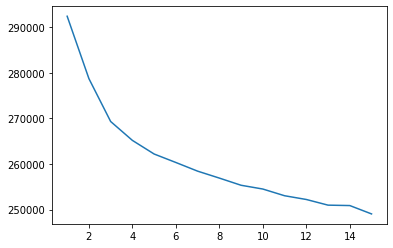

In [148]:
K, inertia = elbow_method(Z, 1, 15)

2. Silhouette score

Silhouette Score = (b-a)/max(a,b)

where

a= average intra-cluster distance i.e the average distance between each point within a cluster.

b= average inter-cluster distance i.e the average distance between all clusters.

In [86]:
def silhouette_score(X, cluster_labels, centroids):
    C = np.array([centroids[k] for k in cluster_labels])
    
    #Compute the average of distances between each point and its centroid
    dist = np.linalg.norm(X-C, axis = 1)
    intra_cluster = np.mean(dist)
    
    #Compute the average of distances between each centroid
    L=[]
    for i in range(len(centroids)) : 
        c1 = centroids[i]
        for j in range(i+1, len(centroids)) : # avoid to compute the distance twice
            c2 = centroids[j]
            if (c1 != c2).any() :
                L.append(np.linalg.norm(c1-c2))
    inter_cluster = np.mean(np.array(L))
    
    silhouette_score = (inter_cluster - intra_cluster) / max(intra_cluster, inter_cluster)
    return silhouette_score
    

In [146]:
def silhouette_method(X, k_min, k_max):
    silhouette_scores = []
    K = []
    for k in range(k_min, k_max + 1):
        cluster_labels, centroids, count  = KMeans(X,k)
        #S = silhouette_score(X, cluster_labels, centroids)
        S = sklearn.metrics.silhouette_score(X, cluster_labels)
        silhouette_scores.append(S)
        K.append(k)
        print(k)
    plt.plot(K, silhouette_scores)
    plt.show()
    return K, silhouette_scores

On Z, reduced data with ACP

2
3
4
5
6
7
8
9
10


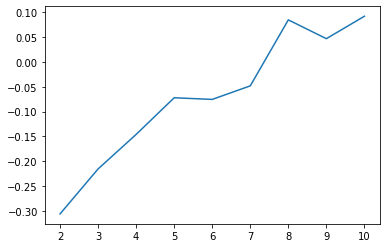

In [147]:
K, silhouette_scores = silhouette_method(Z, 2, 10)

#### Clustering with KMeans ++

In [107]:
kmeans = cluster.KMeans(n_clusters=5, init = 'k-means++', random_state=0).fit(Z)

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://n

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\aurel\Downloads\Anaconda3\lib\site-

In [108]:
kmeans_plus_pred = kmeans.labels_

In [109]:
kmeans_random_pred = KMeans(Z, 5, max_it = 100)

In [110]:
print('Kmeans ++ :', kmeans_plus_pred[:100])
print('Kmeans hom:', kmeans_random_pred[0][:100])

Kmeans ++ : [2 2 2 1 2 4 0 0 0 1 4 0 4 1 3 4 1 1 4 1 4 1 1 1 1 4 1 3 0 0 2 0 0 0 3 3 0
 0 0 4 3 0 0 0 3 0 0 4 0 0 0 0 4 4 2 0 0 4 4 0 4 1 1 4 4 0 0 4 0 0 0 4 2 4
 0 2 0 0 0 2 0 2 0 0 0 4 4 2 2 0 0 0 0 1 4 0 2 0 0 0]
Kmeans hom: [4 4 4 2 4 3 0 0 0 2 3 0 3 2 0 3 2 2 3 2 3 2 2 2 2 3 2 1 0 1 4 0 0 0 1 1 0
 0 0 3 1 1 0 0 1 0 0 3 0 0 0 0 3 3 4 0 0 3 3 0 3 2 2 3 3 0 0 3 0 0 0 3 4 3
 0 4 0 0 0 4 0 4 0 0 0 3 3 4 4 0 0 0 0 3 3 0 4 0 0 0]


### Analyse the result and compare it
...


### 2.4 Analysing your results!

#### Choose relevant attributes
* 'track_language_code' --> Language
* 'track_duration' --> Duration
* 'track_date_created' or 'track_date_recorded' or 'album_date_created' or 'album_date_created' --> Date
* ~~'artist_location'~~,  'metadata_artist_location'--> Country/Region/State
*  'artist_name'--> Artist
* 'artist_associated_labels' --> Label
* ??? 'artist_active_year_begin','artist_active_year_end' ???
* ~~'track_composer' --> Composer~~
* ~~'track_lyricist' --> Lyricist~~


#### Numerical variables --> 4 categories 

In [149]:
merged_df_bis = pd.read_csv('merged_df.csv')

# for variables which represent dates we will use the datetime type
res = []
for col in merged_df_bis.columns:
    if ('date' in col) or ('year' in col):
        merged_df_bis[col] = pd.to_numeric(pd.to_datetime(merged_df_bis[col], format = "%Y-%m-%d"))


C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (811,816,818) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [150]:
relevant_variables = merged_df_bis[['track_language_code', 'track_duration', 'track_date_created', 'metadata_artist_location', 'artist_name']]

In [151]:
relevant_variables.head()

,track_language_code,track_duration,track_date_created,metadata_artist_location,artist_name
0,en,168,1227664092000000000,"Georgia, US",AWOL
1,en,237,1227664094000000000,"Georgia, US",AWOL
2,en,206,1227664100000000000,"Georgia, US",AWOL
3,en,161,1227635346000000000,"Philadelphia, PA, US",Kurt Vile
4,en,207,1227663799000000000,"Georgia, US",AWOL


In [152]:
relevant_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   track_language_code       5823 non-null   object
 1   track_duration            13129 non-null  int64 
 2   track_date_created        13129 non-null  int64 
 3   metadata_artist_location  9770 non-null   object
 4   artist_name               13129 non-null  object
dtypes: int64(2), object(3)
memory usage: 513.0+ KB


In [153]:
# either we make categories with the same width
# or we make categories with the same number of values

18
3033


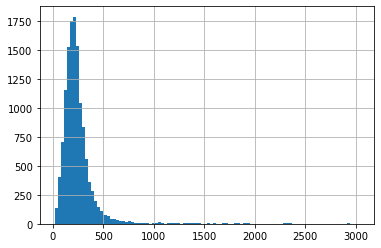

In [154]:
# 'track_duration' is integer/numerical variable so we have to make 4 categories 
print(relevant_variables['track_duration'].min())
print(relevant_variables['track_duration'].max())
relevant_variables['track_duration'].hist(bins = 100)
plt.show()


In [155]:
#col = relevant_variables['track_duration']
#relevant_variables['track_duration_categories'] = ((col - min(col))/(min(col) + max(col))*4).round(0)
#relevant_variables['track_duration_categories'].hist()

In [156]:
# 'track_date_created' is integer/numerical variable so we have to make 4 categories 
#relevant_variables['track_date_created'] = preprocessing.StandardScaler().fit_transform(relevant_variables[['track_date_created']].to_numpy())

col = relevant_variables['track_duration']

threshold_0 = col.min()
threshold_1 = sorted(col)[len(col)//4]
threshold_2 = sorted(col)[len(col)//4 * 2]
threshold_3 = sorted(col)[len(col)//4 * 3]
threshold_4 = col.max()

relevant_variables['track_duration_categories'] = 0
relevant_variables['track_duration_categories'].loc[(threshold_0 <= col) & (col < threshold_1)] = 1
relevant_variables['track_duration_categories'].loc[(threshold_1 <= col) & (col < threshold_2)] = 2
relevant_variables['track_duration_categories'].loc[(threshold_2 <= col) & (col < threshold_3)] = 3
relevant_variables['track_duration_categories'].loc[(threshold_3 <= col) & (col <= threshold_4)] = 4

relevant_variables['track_duration_categories']

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0        2
1        3
2        2
3        2
4        2
        ..
13124    3
13125    3
13126    4
13127    4
13128    4
Name: track_duration_categories, Length: 13129, dtype: int64

1227635346000000000
1441973409000000000


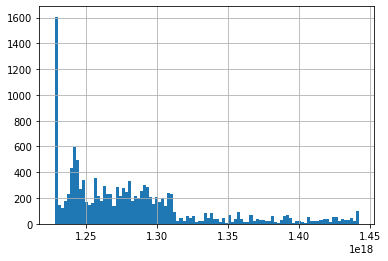

In [157]:
# 'track_date_created' is integer/numerical variable so we have to make 4 categories 
#relevant_variables['track_date_created'] = preprocessing.StandardScaler().fit_transform(relevant_variables[['track_date_created']].to_numpy())
print(relevant_variables['track_date_created'].min())
print(relevant_variables['track_date_created'].max())
relevant_variables['track_date_created'].hist(bins = 100)


In [158]:
# 'track_date_created' is integer/numerical variable so we have to make 4 categories 
#relevant_variables['track_date_created'] = preprocessing.StandardScaler().fit_transform(relevant_variables[['track_date_created']].to_numpy())

col = relevant_variables['track_date_created']

threshold_0 = col.min()
threshold_1 = sorted(col)[len(col)//4]
threshold_2 = sorted(col)[len(col)//4 * 2]
threshold_3 = sorted(col)[len(col)//4 * 3]
threshold_4 = col.max()

relevant_variables['track_date_created_categories'] = 0
relevant_variables['track_date_created_categories'].loc[(threshold_0 <= col) & (col < threshold_1)] = 1
relevant_variables['track_date_created_categories'].loc[(threshold_1 <= col) & (col < threshold_2)] = 2
relevant_variables['track_date_created_categories'].loc[(threshold_2 <= col) & (col < threshold_3)] = 3
relevant_variables['track_date_created_categories'].loc[(threshold_3 <= col) & (col <= threshold_4)] = 4

relevant_variables['track_date_created_categories']

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


0        1
1        1
2        1
3        1
4        1
        ..
13124    4
13125    4
13126    4
13127    4
13128    4
Name: track_date_created_categories, Length: 13129, dtype: int64

#### add the prediction of the clusters

In [159]:
merged_df_bis['pred_clusters'] = kmeans_random_pred[0]
relevant_variables['pred_clusters'] = kmeans_random_pred[0]
relevant_variables['Unnamed: 0']= merged_df_bis['Unnamed: 0']

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Create the pivot tables

In [160]:
variables = ['track_language_code', 'track_duration_categories', 'track_date_created_categories', 'metadata_artist_location', 'artist_name'] # 
pivot_tables = []
for var in variables :
    table = pd.pivot_table(relevant_variables, index = var,  values= 'Unnamed: 0',
                           columns = ['pred_clusters'], aggfunc = 'count', fill_value=0)
    table = table.apply(lambda col : col/sum(col)*100).round(2)
    pivot_tables.append((var, table))
    

In [161]:
for i in range(len(variables)):
    print('Pivot Tables of the variables :', pivot_tables[i][0], '\n')
    print(pivot_tables[i][1], '\n\n\n')

Pivot Tables of the variables : track_language_code 

pred_clusters            0      1      2      3      4
track_language_code                                   
ar                    0.34   0.00   0.00   0.00   0.08
bm                    0.09   0.00   0.00   0.00   0.00
cs                    0.00   0.00   0.11   0.05   0.00
de                    0.09   0.00   0.00   0.16   0.00
el                    0.00   0.00   0.43   0.05   0.00
en                   96.17  99.81  96.49  95.59  93.89
es                    1.02   0.19   1.81   2.10   3.33
fi                    0.26   0.00   0.00   0.00   0.00
fr                    0.34   0.00   0.00   0.05   1.24
it                    0.43   0.00   0.11   0.21   0.23
ja                    0.00   0.00   0.00   0.00   0.23
ko                    0.00   0.00   0.11   0.00   0.00
pt                    0.68   0.00   0.11   0.26   0.93
ru                    0.00   0.00   0.21   0.42   0.08
sr                    0.00   0.00   0.21   0.21   0.00
sw         

#### Analysis of tables  
### TO DO

#### 2.4.6. Compare the obtained clusters to the reality genre

In [162]:
table = pd.pivot_table(merged_df_bis, index = 'track_genre_top',  values= 'Unnamed: 0',
                           columns = ['pred_clusters'], aggfunc = 'count', fill_value=0)
table = table.apply(lambda col : col/sum(col)*100).round(2)
table

pred_clusters,0,1,2,3,4
track_genre_top,,,,,
Blues,2.11,0.28,0.00,0.64,0.34
Classical,4.40,23.93,0.18,0.29,0.14
Electronic,16.91,5.95,17.49,12.88,54.51
Experimental,0.29,0.28,0.12,0.19,0.10
Folk,28.40,13.97,2.49,6.81,1.06
Hip-Hop,2.23,0.14,5.33,6.01,28.48
Instrumental,1.89,0.83,0.47,0.87,0.48
International,2.57,0.83,1.01,1.57,0.77
Jazz,7.54,2.49,1.13,1.54,1.15


#### 2.4.7 KMeans ++ Analysis

In [163]:
df = pd.merge(features, tracks, on='track_id', how='left')

In [166]:
#drop columns with too few values (almost the half)
col_dropped=[]
for col in df.columns:
    nb_missed = df[col].isna().sum() 
    n = df.shape[0]
    if nb_missed > 50000 :
        print(col)
        col_dropped.append(col)
        df.drop([col], axis = 1, inplace = True)

# for variables which represent dates we will use the datetime type
res = []
for col in df.columns:
    if ('date' in col) or ('year' in col):
        df[col] = pd.to_numeric(pd.to_datetime(df[col], format = "%Y-%m-%d %H:%M:%S"))
        
# store and encode object values + store numerical value in two different DataFrame
encoded_df2 = pd.DataFrame()
num_df2 = pd.DataFrame()

for col in df.columns:
    
    #columns with non-numeric values
    if df[col].dtype == object :
        #replace missing values by 'None'
        df[col].fillna("None", inplace = True)  
        le = preprocessing.LabelEncoder()
        encoded_df2[col]= le.fit_transform(merged_df[col])
    
    #columns with numeric values
    else :
        #replace missing values by the mean of the column
        df[col].fillna(df[col].mean(), inplace = True)
        num_df2[col] = merged_df[col]

C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [174]:
#normalize for ACP
X1 = num_df2.to_numpy()
Z1 = preprocessing.StandardScaler().fit_transform(X1) # normalize

pca = PCA(n_components=51)
A = pca.fit_transform(Z1)

In [177]:
print("The partial variance is equal to :", np.cumsum(pca.explained_variance_ratio_)[-1])

The partial variance is equal to : 0.7030066258622892


In [179]:
X2 = encoded_df2.to_numpy()
Z2 = preprocessing.StandardScaler().fit_transform(X2)

# final reducted matrix
Z2 = np.hstack((A, Z2))
Z2.shape

(13129, 67)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


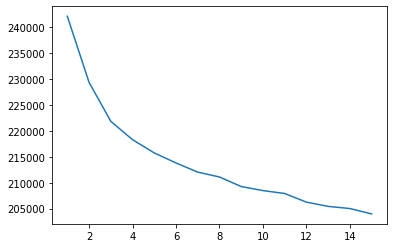

In [180]:
K, inertia = elbow_method(Z2, 2, 15)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


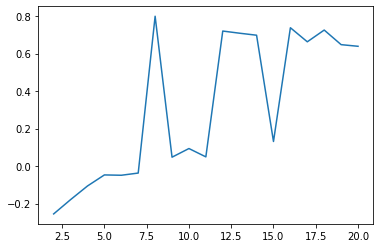

In [183]:
K, silhouette_scores = silhouette_method(Z, 2, 20)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


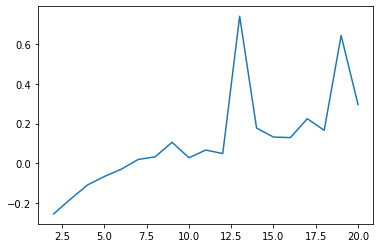

In [184]:
K, silhouette_scores = silhouette_method(Z, 2, 20)

In [ ]:
# Find 5-10 optimal variables












## 3. Algorithmic questions

In [10]:
def pairs(A,s):
    res=[]
    for i in range(len(A)):
        for j in range(i+1, len(A)):
            if A[i]+A[j] == s:
                res.append((A[i],A[j]))
    return res

In [11]:
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 4

print(*pairs(A,s))

(7, -3) (-2, 6) (2, 2) (1, 3)


In [ ]:
#add comments about complexity and ideas